                                          DIAGNOSTIC HOMEWORK
                                             Pedro Armengol

AUXILIARY FUNCTIONS

In [5]:
#Import packages

import csv as csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from dateutil import parser
from datetime import datetime
from censusgeocode import CensusGeocode
import math
import requests
import urllib.parse
import requests


#Parameters

path = "/Users/Usuario/Documents/Chicago/CS_ML/Diagnostic/Data/"

list_names = ["graffiti","abandoned","potholes","sanitation"]



In [6]:
def import_information(name):
    '''
    This function takes a string, imports the information and return a dataframe
    Inputs:
        string (data frame name)
    Outputs:
        Dataframe 
    '''
    csv_file = path + name + ".csv"
    
    df = pd.read_csv(csv_file)

    df = df.rename(columns={'LATITUDE': 'Latitude', 'LONGITUDE': 'Longitude'})
    
    return df


In [28]:
 def adecuate_df(df, name_df):
    '''
    This funtion inputs a dataframe, keep obs. just for 2016 and create the variable lag_attendance
    Input:
        Dataframe
    Output:
        Dataframe
    
    '''  
    #Convert dates into strings and create lag attendance
    if name_df == "graffiti" or name_df == "sanitation":
        df["date_creation"] = pd.to_datetime(df["Creation Date"], format='%m/%d/%Y')
        df["date_completion"] = pd.to_datetime(df["Completion Date"], format='%m/%d/%Y')
    if name_df == "potholes":
        df["date_creation"] = pd.to_datetime(df["CREATION DATE"], format='%m/%d/%Y')
        df["date_completion"] = pd.to_datetime(df["COMPLETION DATE"], format='%m/%d/%Y')
        
    df["lag_attendance"] = df["date_completion"] - df["date_creation"]
    #Restrain the database
    list_year = []
    list_month = []
    for i in range(len(df["date_creation"])):
        year = df["date_creation"][i].year 
        month = df["date_creation"][i].month
        list_year.append(year)
        list_month.append(month)
    df["year"] = list_year
    df["month"] = list_month
    df = df[df["year"]==2016]
    
    return df



In [ ]:
 def descriptive_statistics(df, name_subcategory):
    '''
    Takes a df and creates 4 histograms to describe it.
    Input:
        Dataframe
    Output:
        4 Histograms
    '''
    
    df["count"] = 1
    df1 = df.groupby(["Community Area"]).sum()
    ig, ax = plt.subplots()
    ax.barh(df1.index.values, df1["count"])
    plt.show()
    
    # Plot mean attendance time by community area
    df2 = df.groupby(['Community Area'])['lag_attendance'].describe()
    list_g=list(range(77))
    list_g = map(lambda x: x+1, list_g)
    list_g = list(list_g)
    list_mean = []
    for i in list_g:
        mean = df2[i][1].days
        list_mean.append(mean) 
    fig, ax = plt.subplots()
    ax.barh(list_g, list_mean)
    plt.show()
    #Plot number of graffities by date
    df3 = df.groupby(["date_creation"]).sum()
    df3 = df3["count"]
    df3.plot.line()
    plt.show()
    # Plot mean of response time for each day 
    df4 = df.groupby(['date_creation'])['lag_attendance'].describe()
    list_g = list(range(0,366,8))
    list_g = map(lambda x: x+1, list_g)
    list_g = list(list_g)
    list_mean = []
    for i in list_g:
        mean = df4[i].days
        list_mean.append(mean) 
    fig, ax = plt.subplots()
    ax.barh(list_g, list_mean)
    plt.show()
    #By Subcategory
    df5 = df.groupby([name_subcategory]).sum()
    df6 = df.groupby(["Community Area",name_subcategory]).sum()
    

Functions for the API

In [33]:
def fips_df(df):
    '''
    
    This function returns the separate elements of FIPS: state, county, tract and block group
    
    Input:
        a dataframe with latitutde and logitude columns
    
    Returns:
        a tuple with elements of FIPS
    '''
    
    cg = CensusGeocode()
    

    latitude = df["Latitude"]
    longitude = df["Longitude"]

    latitude = list(latitude)
    longitude = list(longitude)

    #Deal with nans
    long_list1 = []
    for i in range(len(longitude)):
        longitude1 = str(longitude[i])
        if longitude1 != "nan":
            longitude1 = float(longitude1)
        long_list1.append(longitude1)
    longitude = long_list1

    lat_list1 = []

    for i in range(len(latitude)):
        latitude1 = str(latitude[i])
        if latitude1 != "nan":
            latitude1 = float(latitude1)
        lat_list1.append(latitude1)
    latitude = lat_list1

    #GET FIPS
    #fips_list = []
    attributes_list = []

    for i in range(len(latitude)):
        if latitude[i] != "nan":
            result = cg.coordinates(x=longitude[i], y=latitude[i])
            #fips = result[0]['2010 Census Blocks'][0]["GEOID"]
            state = result[0]['2010 Census Blocks'][0]["STATE"]
            county = result[0]['2010 Census Blocks'][0]["COUNTY"]
            tract = result[0]['2010 Census Blocks'][0]["TRACT"]
            block = result[0]['2010 Census Blocks'][0]["BLKGRP"]
            #fips_list.append(fips)
            tuple1 = (state,county,tract,block)
            attributes_list.append(tuple1)
            print(tuple1)

        else:
            fips = "nan"
            state = "nan"
            county = "nan"
            tract = "nan"
            block = "nan"
            #fips_list.append(fips)
            tuple1 = (state,county,tract,block)
            attributes_list.append(tuple1)
            
    return attributes_list



In [34]:
def get_request(url):
    '''
    Open a connection to the specified URL and if successful
    read the data.

    Inputs:
        url: must be an absolute URL
    
    Outputs: 
        request object or None
    '''
    
    try:
        r = requests.get(url)
        if r.status_code == 404 or r.status_code == 403:
            r = None
    except:
        # fail on any kind of error
        r = None

    return r

In [35]:
def variables_lists(df):
    '''
    This function returns the values of three different variables aforementioned and the Block group.
    
    Input:
        a dataframe
        
    Returns:
        a tuple containing three demographic-related variables and the Block group of each complaint.
    
    Note: (in this case)
    
    #var1 = Population of two or more races
    #var2 = Household Income by Gross Rent As A Percentage of Household Income in the Past 12 Months
    #var3 = Owner occupied houses
    
    '''
    attributes_list = fips_df(df)
    var1_list = []
    var2_list = []
    var3_list = []
    block_list = []
    
    for a,b,c,d in attributes_list:
        if a != 'nan':
            var1 = get_request('http://api.census.gov/data/2015/acs5?get=NAME,C02003_012E&for=block+group:' + d + '&in=state:' + a + '&in=county:' + b + '&in=tract:' + c + '&&key=d6faa54ce89cb5d5df9db4fb701e0780140d6640')
            var2 = get_request('http://api.census.gov/data/2015/acs5?get=NAME,B25074_001E&for=block+group:' + d + '&in=state:' + a + '&in=county:' + b + '&in=tract:' + c + '&&key=d6faa54ce89cb5d5df9db4fb701e0780140d6640')
            var3 = get_request('http://api.census.gov/data/2015/acs5?get=NAME,B25009_002E&for=block+group:' + d + '&in=state:' + a + '&in=county:' + b + '&in=tract:' + c + '&&key=d6faa54ce89cb5d5df9db4fb701e0780140d6640')      
            block_list.append(int(d))
            var1_list.append(int(var1.json()[1][1]))
            var2_list.append(int(var2.json()[1][1]))
            var3_list.append(int(var3.json()[1][1]))
        else:
            block_list.append("nan")
            var1_list.append("nan")
            var2_list.append("nan")
            var3_list.append("nan")
                
    return var1_list, var2_list, var3_list, block_list

In [36]:
def variables_lists(df):
    '''
    This function returns the values of three different variables aforementioned and the Block group.
    
    Input:
        a dataframe
        
    Returns:
        a tuple containing three demographic-related variables and the Block group of each complaint.
    '''
    attributes_list = fips_df(df)
    var1_list = []
    var2_list = []
    var3_list = []
    block_list = []
    
    for a,b,c,d in attributes_list:
        if a != 'nan':
            var1 = get_request('http://api.census.gov/data/2015/acs5?get=NAME,C02003_012E&for=block+group:' + d + '&in=state:' + a + '&in=county:' + b + '&in=tract:' + c + '&&key=d6faa54ce89cb5d5df9db4fb701e0780140d6640')
            var2 = get_request('http://api.census.gov/data/2015/acs5?get=NAME,B25074_001E&for=block+group:' + d + '&in=state:' + a + '&in=county:' + b + '&in=tract:' + c + '&&key=d6faa54ce89cb5d5df9db4fb701e0780140d6640')
            var3 = get_request('http://api.census.gov/data/2015/acs5?get=NAME,B25009_002E&for=block+group:' + d + '&in=state:' + a + '&in=county:' + b + '&in=tract:' + c + '&&key=d6faa54ce89cb5d5df9db4fb701e0780140d6640')      
            block_list.append(int(d))
            var1_list.append(int(var1.json()[1][1]))
            var2_list.append(int(var2.json()[1][1]))
            var3_list.append(int(var3.json()[1][1]))
        else:
            block_list.append("nan")
            var1_list.append("nan")
            var2_list.append("nan")
            var3_list.append("nan")
                
    return var1_list, var2_list, var3_list, block_list



In [136]:
def update_vars_df(df):
    '''
    Appends values of three demographic-related variables into the original dataframe
    
    Input:
        a dataframe
    
    Returns:
        updated dataframe
    '''
    df = df[:50] # Using analysis on first 100 rows from 2016 data

    var1_list, var2_list, var3_list, block_list = variables_lists(df)
  
    df['Block'] = block_list
    df['Population of Multiple Races'] = list(map(int,var1_list))
    df['Household Income by Gross Rent ($000)'] = list(map(int,var2_list))
    df['Owner Occupied Houses'] = list(map(int,var3_list))
    return df


QUESTION 1: DESCRIPTIVE STATISTICS



GRAFFITI

In [18]:
graffiti = import_information("graffiti")
list(graffiti)


['Creation Date',
 'Status',
 'Completion Date',
 'Service Request Number',
 'Type of Service Request',
 'What Type of Surface is the Graffiti on?',
 'Where is the Graffiti located?',
 'Street Address',
 'ZIP Code',
 'X Coordinate',
 'Y Coordinate',
 'Ward',
 'Police District',
 'Community Area',
 'SSA',
 'Latitude',
 'Longitude',
 'Location']

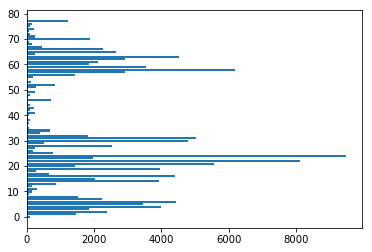

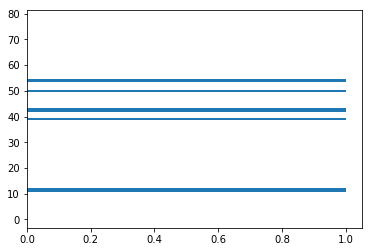

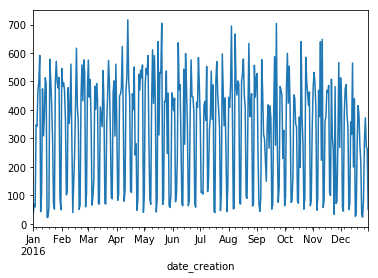

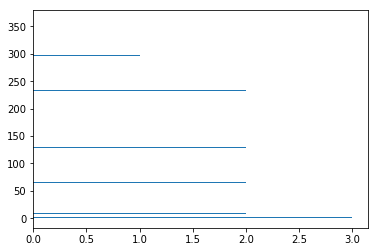

bon bon


In [19]:
graffiti = adecuate_df(graffiti,"graffiti")
descriptive_statistics(graffiti, 'What Type of Surface is the Graffiti on?')


The first two histograms describe the number of graffities and the time of attendance for each community area. In the first histogram there can be seen that there exits a huge hetegoreneity in the number of graffities between community areas. In some of them there are thousends of graffities meanwhile in others there are just a couple of dozens. The second histogram shows that just five communities have a gap between the time of notification and the time of response. In the analysis by day, is evident that there is an intertemporal correlation in the number of graffities: more graffities in period one are related to a decrease in the number of graffities the following one.

POTHOLES

In [21]:
potholes = import_information("potholes")
list(potholes)

['CREATION DATE',
 'STATUS',
 'COMPLETION DATE',
 'SERVICE REQUEST NUMBER',
 'TYPE OF SERVICE REQUEST',
 'CURRENT ACTIVITY',
 'MOST RECENT ACTION',
 'NUMBER OF POTHOLES FILLED ON BLOCK',
 'STREET ADDRESS',
 'ZIP',
 'X COORDINATE',
 'Y COORDINATE',
 'Ward',
 'Police District',
 'Community Area',
 'SSA',
 'Latitude',
 'Longitude',
 'LOCATION']

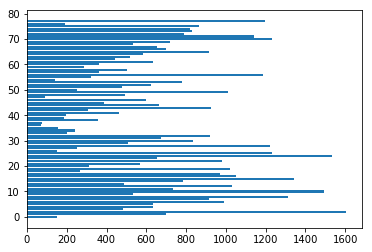

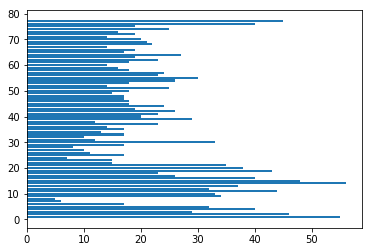

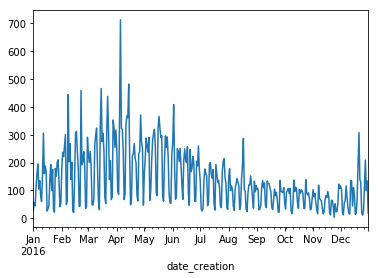

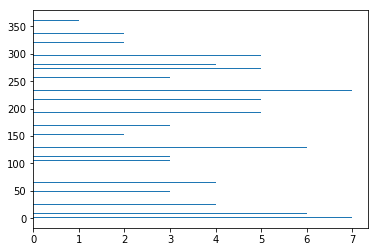

bon bon


In [25]:
potholes = adecuate_df(potholes,"potholes")    
descriptive_statistics(potholes,'TYPE OF SERVICE REQUEST')


Again, there is a huge heterogeneity between community areas in the number of potholes as well as in the time of response by the city. However, is interesting to notice that the calls decrease in the fall quarter an increase in the spring quarter. Probably, the season trends are driven by the weather conditions and they impact on the streets. 

SANITATION

In [26]:
sanitation = import_information("sanitation")
list(sanitation)

['Creation Date',
 'Status',
 'Completion Date',
 'Service Request Number',
 'Type of Service Request',
 'What is the Nature of this Code Violation?',
 'Street Address',
 'ZIP Code',
 'X Coordinate',
 'Y Coordinate',
 'Ward',
 'Police District',
 'Community Area',
 'Latitude',
 'Longitude',
 'Location']

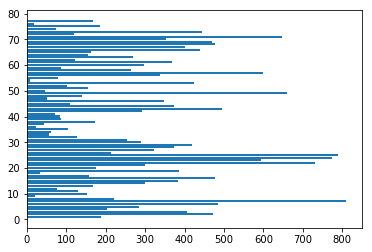

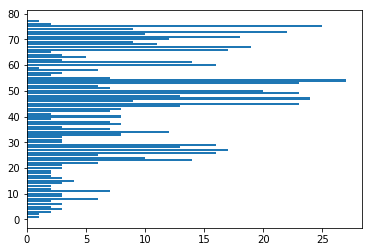

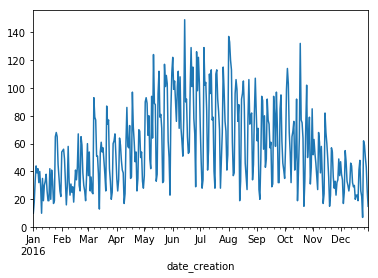

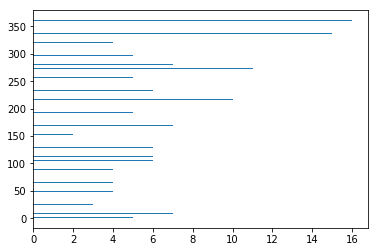

bon bon


In [29]:
sanitation = adecuate_df(sanitation,"sanitation")    
descriptive_statistics(sanitation,'What is the Nature of this Code Violation?')

Finally, the sanitation claims also are heterogeneous between community areas and time of response: the former ones varying between 2 and 25 days (depending on the area). Is interesting to notice that the mayority of the claims where concentrated on the summer meanwhile the less quantitites where concentrated on the winter. As well, the response time was bigger on summer than in winter: probably related to the work load of the sanitation response teams.

QUESTION 2: API



API FOR THE FIRST 50 OBS. OF THE GRAFFITI DATAFRAME 

In [137]:
graffiti_api = update_vars_df(graffiti)



('17', '031', '210601', '2')
('17', '031', '660500', '1')
('17', '031', '320600', '2')
('17', '031', '620100', '1')
('17', '031', '210502', '3')
('17', '031', '611700', '1')
('17', '031', '560800', '2')
('17', '031', '031700', '2')
('17', '031', '190200', '1')
('17', '031', '650302', '1')
('17', '031', '830700', '3')
('17', '031', '230800', '1')
('17', '031', '070700', '2')
('17', '031', '832200', '2')
('17', '031', '832200', '2')
('17', '031', '832200', '2')
('17', '031', '832200', '2')
('17', '031', '832200', '2')
('17', '031', '220300', '2')
('17', '031', '220300', '2')
('17', '031', '210602', '2')
('17', '031', '210502', '3')
('17', '031', '171000', '2')
('17', '031', '171000', '2')
('17', '031', '171000', '2')
('17', '031', '171000', '1')
('17', '031', '190401', '1')
('17', '031', '190401', '1')
('17', '031', '241500', '3')
('17', '031', '230400', '2')
('17', '031', '221100', '3')
('17', '031', '630300', '1')
('17', '031', '520400', '3')
('17', '031', '840300', '2')
('17', '031', 

/Users/Usuario/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Usuario/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Usuario/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

DESCRIPTIVE STATISTICS FOR EACH CENSUS BLOCK TYPE (CHICAGO)

In [148]:
descriptive1 = pd.DataFrame(graffiti_api.groupby('Block')["lag_attendance"].sum())
descriptive2 = pd.DataFrame(graffiti_api.groupby('Block')["count"].sum())
descriptive = descriptive1.merge(descriptive2, left_index = True, right_index = True)

descriptive3 = pd.DataFrame(graffiti_api.groupby('Block')["count"].mean())
descriptive = descriptive.merge(descriptive3, left_index = True, right_index = True)

descriptive4 = pd.DataFrame(graffiti_api.groupby('Block')['Population of Multiple Races'].mean())
descriptive = descriptive.merge(descriptive4, left_index = True, right_index = True)

descriptive5 = pd.DataFrame(graffiti_api.groupby('Block')['Household Income by Gross Rent ($000)'].mean())
descriptive = descriptive.merge(descriptive5, left_index = True, right_index = True)

descriptive6 = pd.DataFrame(graffiti_api.groupby('Block')['Owner Occupied Houses'].mean())
descriptive = descriptive.merge(descriptive6, left_index = True, right_index = True)

descriptive = descriptive.rename(columns={'count_x': '# of Graffities', 'count_y': 'Average # of Graffities', 'lag_attendance': "# Days to clear the Graffti"})
print(descriptive)
#descriptive = descriptive.agg([graffiti_api["lag_attendance"].sum(),graffiti_api["Population of Multiple Races"].mean()])






       # Days to clear the Graffti  # of Graffities  Average # of Graffities  \
Block                                                                          
1                           8 days               15                        1   
2                          13 days               26                        1   
3                           4 days                7                        1   
4                           0 days                2                        1   

       Population of Multiple Races  Household Income by Gross Rent ($000)  \
Block                                                                        
1                         39.333333                             205.866667   
2                         35.576923                             348.961538   
3                         11.571429                             252.571429   
4                         29.000000                              94.500000   

       Owner Occupied Houses  
Block              

QUESTION 3: PROBABILITIES OF OCURRENCE

Answer 1

In [154]:
sum1 = graffiti.groupby('count')['count'].sum()
graffiti1 = graffiti[graffiti['Street Address'] == '7500 S Wolcott Ave']
sum2 = graffiti1.groupby('count')['count'].sum()
prob_graffiti = sum2/(sum1+1)
print(prob_graffiti)

count
1   NaN
Name: count, dtype: float64


In [155]:
sum1 = potholes.groupby('count')['count'].sum()
potholes1 = potholes[potholes['STREET ADDRESS'] == '7500 S Wolcott Ave']
sum2 = potholes1.groupby('count')['count'].sum()
prob_potholes = sum2/(sum1+1)
print(prob_potholes)


count
1   NaN
Name: count, dtype: float64


In [156]:
sum1 = sanitation.groupby('count')['count'].sum()
sanitation1 = sanitation[sanitation['Street Address'] == '7500 S Wolcott Ave']
sum2 = sanitation1.groupby('count')['count'].sum()
prob_sanitation = sum2/(sum1+1)
print(prob_sanitation)


count
1   NaN
Name: count, dtype: float64


In [157]:
abandoned = import_information("abandoned")
list_year = []
abandoned["date_creation"] = pd.to_datetime(abandoned['DATE SERVICE REQUEST WAS RECEIVED'], format='%m/%d/%Y')

for i in range(len(abandoned["date_creation"])):
    year = abandoned["date_creation"][i].year 
    list_year.append(year)
abandoned["year"] = list_year
abandoned = abandoned[abandoned["year"]==2016]
abandoned["count"] = 1
sum1 = abandoned.groupby('count')['count'].sum()
sanitation1 = abandoned[abandoned['ADDRESS STREET DIRECTION'] == '7500 S Wolcott Ave']
sum2 = abandoned.groupby('count')['count'].sum()
prob_abandoned = sum2/(sum1+1)
print(prob_sanitation)



/Users/Usuario/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


count
1   NaN
Name: count, dtype: float64


The four of them have frecuent probability zero of happening in the address: 7500 S Wolcott Ave. In other words, the probability of a call coming for an specific request of the four types is the same.

Answer 2

In [162]:
#UPTOWN PROB
sum1 = graffiti.groupby('count')['count'].sum()
graffiti1 = graffiti[graffiti["Community Area"] == 3]
sum2 = graffiti1.groupby('count')['count'].sum()
prob_graffiti1 = sum2/(sum1+1)
print("Uptown")
print(prob_graffiti1)
#NORTH LAWNDALE PROB
graffiti1 = graffiti[graffiti["Community Area"] == 29]
sum2 = graffiti1.groupby('count')['count'].sum()
prob_graffiti2 = sum2/(sum1+1)
print("North Lawndale")
print(prob_graffiti2)


Uptown
count
1    0.015216
Name: count, dtype: float64
North Lawndale
count
1    0.004109
Name: count, dtype: float64


In [168]:
num = prob_graffiti1/prob_graffiti2
print(num)
print("Coming from North Lawndale is 2/3 less likely that coming from Uptown")


count
1    3.70303
Name: count, dtype: float64
Coming from North Lawndale is 2/3 less likely that coming from Uptown


Answer 3

Using the Bayes theorem, we can say that the probability that a call came from Uptown given that is about graffiti is almost as twice as big (61.53%) that the probability that the same call came from North Lawndale (38.0%). 